In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import jax
from jax import numpy as jnp
import matplotlib.pyplot as plt
from jax import random
import numpy as np
from scipy.integrate import solve_ivp
from numpy.linalg import eigvalsh
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

from configs import Lorenz63Config, LorenzSystem
from models import lorenz63_step 
from metrics import rmse
from plotting import (
    plot_rmse_stackplot,
    plot_cross_val,
    create_sigma_histogram,
    create_rmse_heatmap,
)

from cost_functions import (
    bayes_cost_function,
    dci_cost_function,
    dci_wme_cost_function,
)


os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
jax.config.update("jax_enable_x64", True)

/var/folders/14/4_5vrl2912bc84l063zdm5l80000gq/T/ipykernel_69566/652856800.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
print(jax.__version__) # Make sure JAX is set to version 0.5.2

0.5.2


Bad pipe message: %s [b'\x8b\x8b\x8b\x8b\x8b\x8b\xe2\xfb\xe8\xa5\xec\xee\xff\xe8\xe3\xea\xe5\xe5\xee\xe7\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\x8b\xa9$\xd7\xa2\x8a\x8b\x8b\x8b\x8b\xa5\x00\x00\x00\x97\x07\xde\x10jgmhkp+^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^;&*;0-710p7.=^^^^^^^^^^^^^^^^^^^^^^^^', b'*;0-710p7.=^^^^^^^^^^^^^^^^^^^^^^^^7.=p9;*=6?00;2^^^^^^^^^']


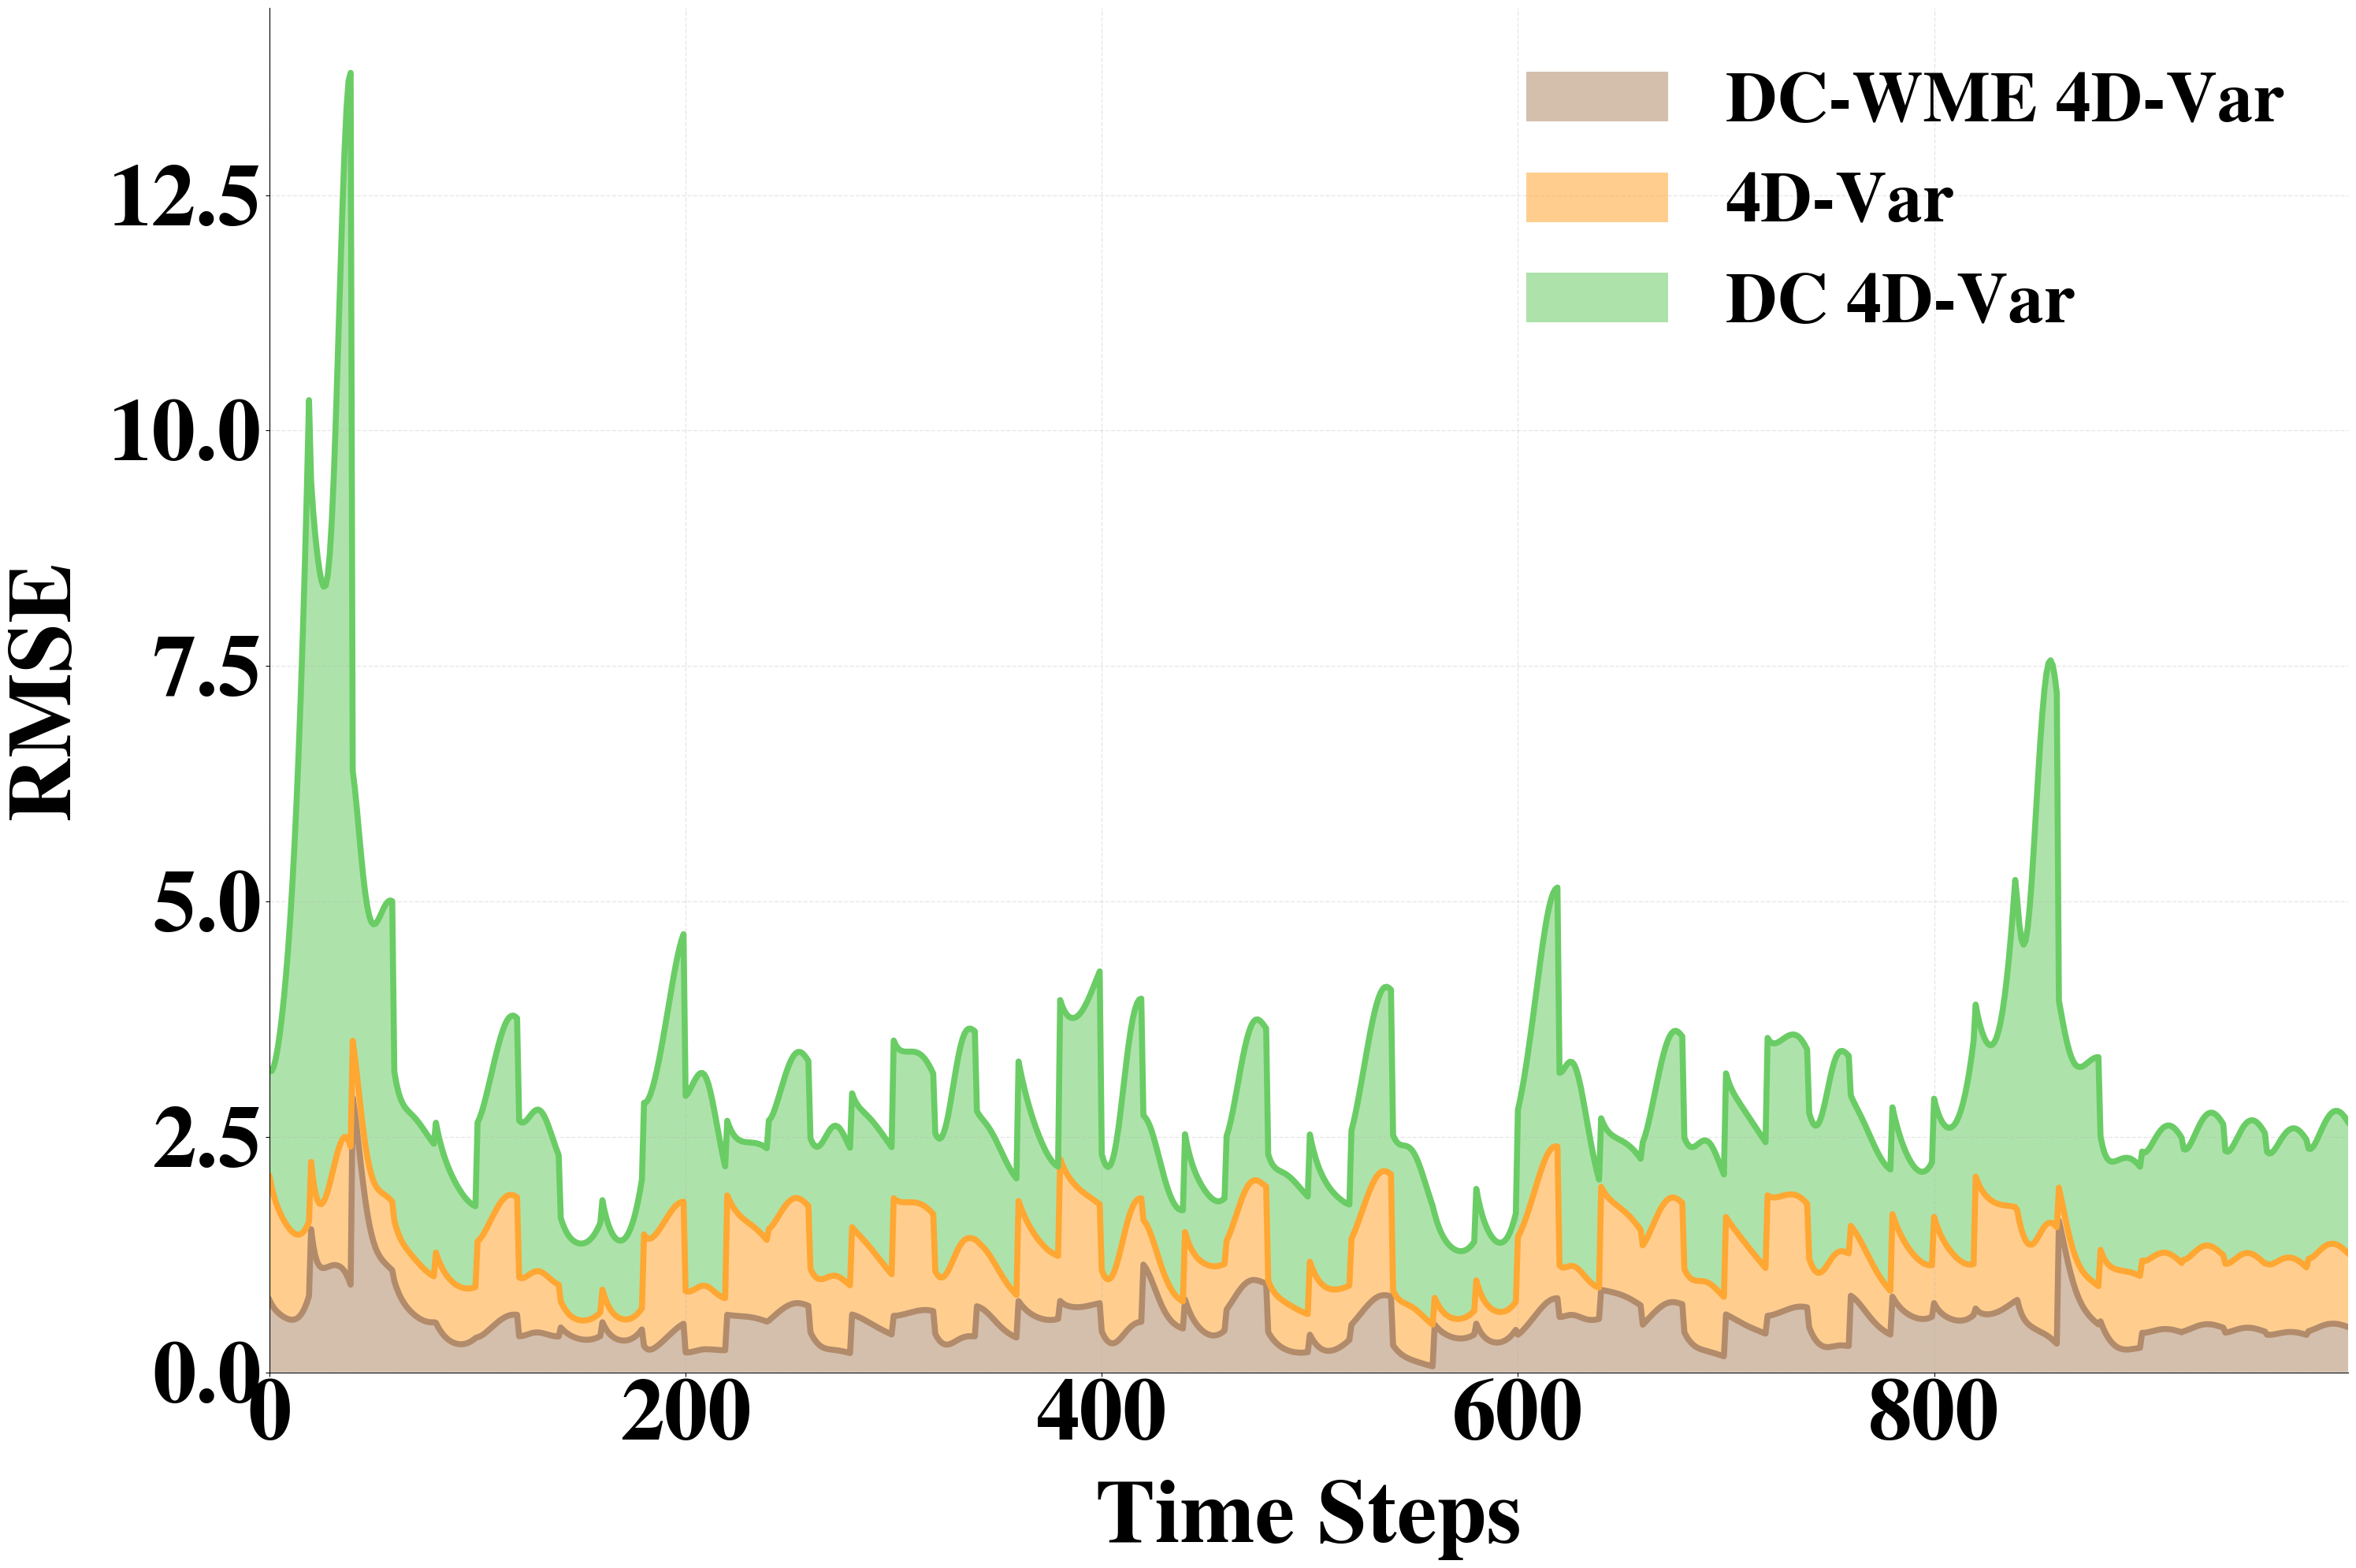

In [2]:
# Main execution function
cost_functions = {
    'Bayes': bayes_cost_function,
    'DCI': dci_cost_function,
    'DCI_WME': dci_wme_cost_function
}

# Create system and run experiment
config_avg = Lorenz63Config.default_config(
    total_steps=1000, window_size=20, obs_frequency=4, 
    obs_std=2.0, inflation_factor=12
)
system_avg = LorenzSystem(config_avg, lorenz63_step, cost_functions)
results_avg = system_avg.run_experiment()

# Create results dataframe
df_avg = pd.DataFrame.from_dict(results_avg['results'], orient='index')

# Calculate RMSE scores for all models
rmse_scores = pd.DataFrame({
    model: rmse(results_avg['analysis'][model], results_avg['trajectory'])
    for model in cost_functions.keys()
})

plot_params = {
    "lines.linewidth": 8,
    "lines.markersize": 25,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 65,
    "legend.frameon": False,
    "legend.title_fontsize": "50",
    "xtick.labelsize": 80,
    "ytick.labelsize": 80,
    "axes.labelsize": 82,
    "axes.labelpad": 20,
    "axes.titlesize": 50,
    "figure.figsize": (30, 20),
}

fig, ax = plot_rmse_stackplot(rmse_scores, plot_params=plot_params, save=False)

_____

In [3]:
cost_functions = {'DCI_WME': dci_wme_cost_function}
noise_levels = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
obs_freqs = [4, 5, 10]

rmse_noise_dfs, misfit_noise_dfs, rel_error_noise_dfs = [], [], []

for obs_freq in obs_freqs:
    # Run experiments for all noise levels
    dfs = []
    for noise in noise_levels:
        config = Lorenz63Config.default_config(
            total_steps=500, window_size=20, obs_frequency=obs_freq, 
            obs_std=noise, inflation_factor=4*(noise**2)
        )
        system = LorenzSystem(config, lorenz63_step, cost_functions)
        results = system.run_experiment()
        dfs.append(pd.DataFrame.from_dict(results['results'], orient='index'))
    
    # Concatenate and store results
    metrics = ['rmse', 'misfit', 'relative_error']
    for metric, storage in zip(metrics, [rmse_noise_dfs, misfit_noise_dfs, rel_error_noise_dfs]):
        combined = pd.concat([getattr(df, metric) for df in dfs], axis=1)
        combined.columns = noise_levels
        storage.append(combined)

# Create final observation density dataframe
obs_df = pd.concat([
    df.assign(Observation_Density=freq) 
    for df, freq in zip(rmse_noise_dfs, obs_freqs)
])


dci_wme_obs = obs_df.loc['DCI_WME']
dci_wme_obs = dci_wme_obs.iloc[::-1]
dci_wme_obs = dci_wme_obs.set_index('Observation_Density')
dci_wme_obs

,0.5,1.0,1.5,2.0,2.5,3.0
Observation_Density,,,,,,
10,0.795305,0.954732,1.175806,1.428068,1.699049,1.990436
5,0.573151,0.600097,0.676943,0.787706,0.924439,1.079842
4,0.529959,0.516487,0.529753,0.563096,0.610467,0.672299


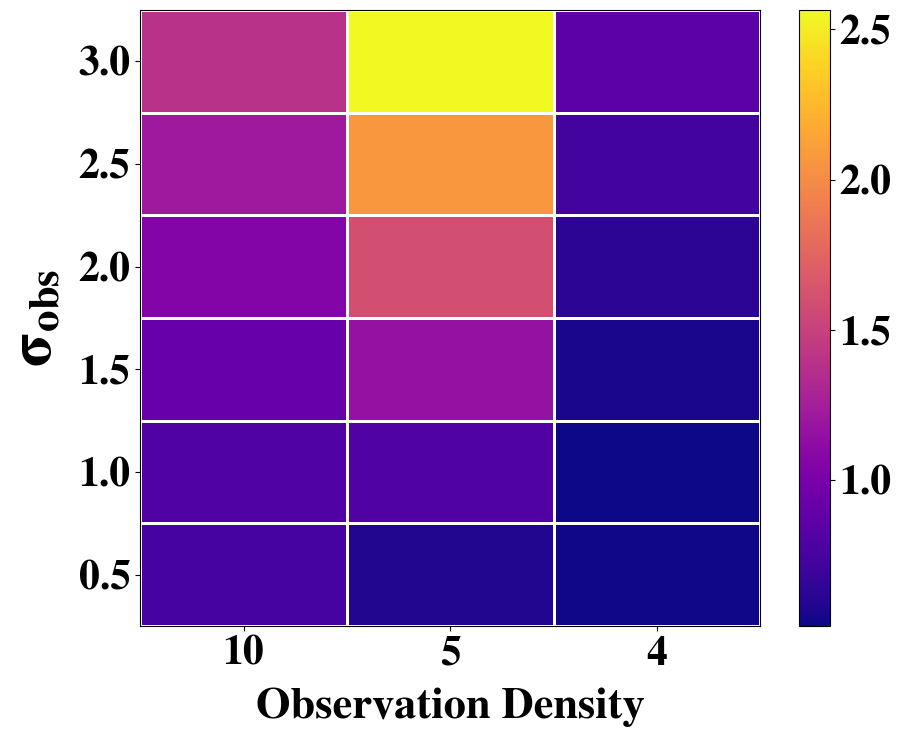

In [8]:
plot_params = {
    "lines.linewidth": 10,
    "lines.markersize": 20,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 30,
    "legend.frameon": False,
    "legend.title_fontsize": 20,
    "xtick.labelsize": 30,
    "ytick.labelsize": 30,
    "axes.labelsize": 32,
    "axes.labelpad": 10,
    "axes.titlesize": 20,
    "figure.figsize": (10, 8),
    'font.weight': 'bold',
}

plot_cross_val(dci_wme_obs.T, plot_params, file_name="dci_wme_noisevdensity")

____

In [2]:
# Lorenz 63 parameters
sigma, rho, beta = 10.0, 28.0, 8.0/3.0

def lorenz63(t, state):
    """Lorenz 63 system"""
    x, y, z = state
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

def lorenz63_jacobian(state):
    """Jacobian of Lorenz 63"""
    x, y, z = state
    return np.array([
        [-sigma, sigma, 0],
        [rho - z, -1, -x],
        [y, x, -beta]
    ])

def propagate_jacobian(z0, t_final, dt=0.01):
    """Tangent linear propagation of Jacobian"""
    n, J, z, t = len(z0), np.eye(len(z0)), np.array(z0), 0.0
    
    while t < t_final:
        A = lorenz63_jacobian(z)
        J += dt * A @ J
        z += dt * np.array(lorenz63(0, z))
        t += dt
    return J

# Parameters and setup
gamma, sigma_obs_sq, N_obs, t_final = 0.1, 2.0, 5, 10.0
H = np.array([[1, 0, 0], [0, 1, 0]])  # Observation operator

# Generate initial conditions and compute bounds
np.random.seed(0)
initial_conditions = np.random.uniform(-5, 5, size=(50, 3))

def compute_bound(z0):
    """Compute bound for given initial condition"""
    Q = H @ propagate_jacobian(z0, t_final)
    lambda_min = eigvalsh(Q @ Q.T).min()
    return (gamma * sigma_obs_sq**2) / (N_obs * lambda_min)

bounds = [compute_bound(z0) for z0 in initial_conditions]

average_bound = np.mean(bounds)
print(f"Average estimated lower bound on $\\sigma_b^2$ over 50 trajectories: {average_bound:.3f}")


Average estimated lower bound on $\sigma_b^2$ over 50 trajectories: 16.830


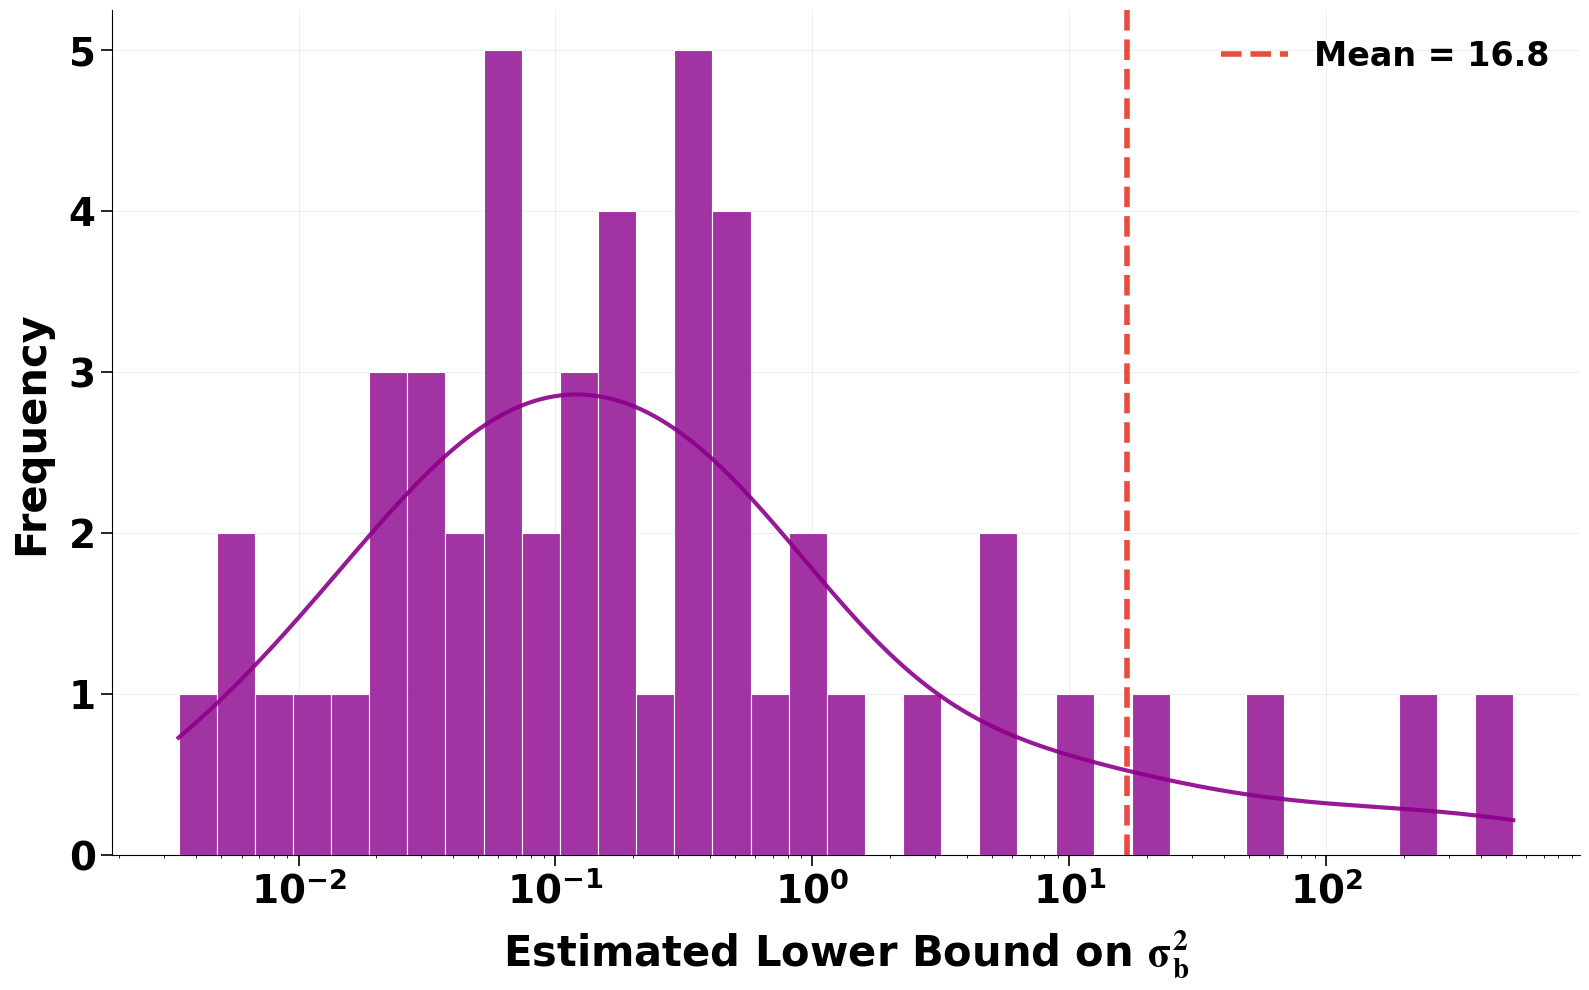

In [3]:
plot_params = {
    "lines.linewidth": 4,
    "lines.markeredgecolor": "black",
    "legend.fontsize": 24,
    "legend.frameon": False,
    "xtick.labelsize": 28,
    "ytick.labelsize": 28,
    "axes.labelsize": 30,
    "axes.labelpad": 12,
    "figure.figsize": (16, 10),
    "axes.titleweight": "bold",
    "axes.labelweight": "bold",
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
}
data = np.array(bounds)  # Replace with actual data
fig, ax = create_sigma_histogram(data, plot_params)

____

In [4]:
# Define cost functions
cost_functions = {
    '4DVar': bayes_cost_function,
    'DCI': dci_cost_function,
    'DCI_WME': dci_wme_cost_function
}

noise_levels = [0.25, 1.  , 2.25, 4.  , 6.25, 9.  ]
inflation_factors = 4.0*jnp.array(noise_levels)
pair_levels = list(zip(noise_levels, inflation_factors.tolist()))
noise_inflate_dfs = []
for level, inflation_factor in tqdm(pair_levels, desc="Running Inflation Level Sensitivity"):
    config = Lorenz63Config.default_config(total_steps=1000, window_size=20, obs_frequency=4, obs_std=jnp.sqrt(level), inflation_factor=inflation_factor)
    system = LorenzSystem(config, lorenz63_step, cost_functions)
    results = system.run_experiment()
    df = pd.DataFrame.from_dict(results['results'], orient='index')
    noise_inflate_dfs.append(df)

pair_rmse_inflate = pd.concat(map(lambda df: df.rmse, noise_inflate_dfs), axis=1)
pair_levelsmisfit_inflate = pd.concat(map(lambda df: df.misfit, noise_inflate_dfs), axis=1)
pair_rel_error_inflate = pd.concat(map(lambda df: df.relative_error, noise_inflate_dfs), axis=1)
pair_levelsmisfit_inflate.columns = pair_levels
pair_rmse_inflate.columns = pair_levels
pair_rel_error_inflate.columns = pair_levels

Running Inflation Level Sensitivity: 100%|██████████| 6/6 [01:06<00:00, 11.06s/it]


In [12]:
pair_rmse_inflate

,"(0.25, 1.0)","(1.0, 4.0)","(2.25, 9.0)","(4.0, 16.0)","(6.25, 25.0)","(9.0, 36.0)"
4DVar,0.275196,0.446649,0.649395,0.861042,1.074900,1.289945
DCI,0.494437,0.781562,1.083091,1.386239,1.689483,1.992052
DCI_WME,0.435238,0.451387,0.487220,0.539198,0.602742,0.675743


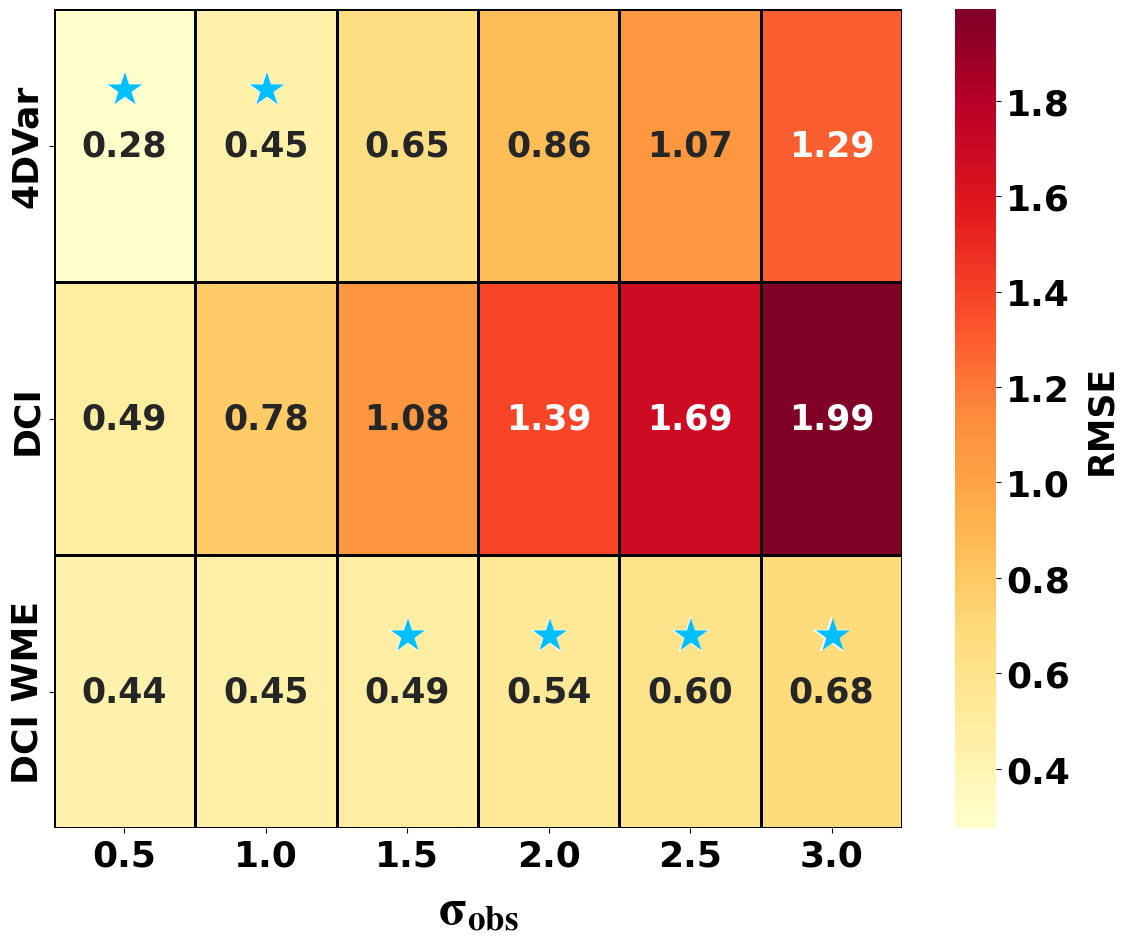

In [5]:
df = pd.DataFrame({
    'Sigma': np.sqrt(noise_levels),
    'Alpha': inflation_factors,
    '4DVar': pair_rmse_inflate.loc['4DVar'].values,
    'DCI': pair_rmse_inflate.loc['DCI'].values,
    'DCI WME': pair_rmse_inflate.loc['DCI_WME'].values
})
df_melt = df.melt(id_vars=['Sigma', 'Alpha'], var_name='Method', value_name='RMSE')

plot_params = {
    "lines.linewidth": 2,
    "xtick.labelsize": 26,
    "ytick.labelsize": 26,
    "axes.labelpad": 10,
    "figure.figsize": (12, 10),
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "text.usetex": False,
    "mathtext.fontset": "stix",
    "mathtext.default": "bf",
    "font.family": "sans serif",
    "font.weight": "bold",
    "font.size": 25,
    "axes.titleweight": "bold",
}

fig, ax, pivot = create_rmse_heatmap(df_melt, plot_params)